In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

from IPython.display import clear_output

format = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

    transforms.RandomCrop((400, 400)),
    transforms.RandomRotation(180),

    transforms.CenterCrop((282, 282)), # 282 ~= 400 * (1/sqrt(2))
    transforms.Resize((256, 256), transforms.InterpolationMode.NEAREST),

    transforms.RandomApply(p=0.2, transforms=[transforms.GaussianBlur(5, sigma=(.5, 12))]),
    transforms.RandomApply(p=0.2, transforms=[transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.5)]),

    transforms.ToTensor(),
])
ds = datasets.Flowers102(root='../pytorch-datasets/', split='train', transform=format, download=True)
dl = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=True)

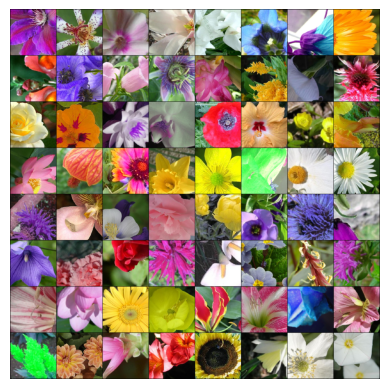

In [2]:
for batch_i, (batch, labels) in enumerate(dl):
    imgs = make_grid(batch, nrow=8, pad_value=0)
    # save_image(imgs, 'flowers.png')
    plt.imshow(imgs.permute(1, 2, 0), )
    plt.axis('off')
    plt.show()
    break

In [3]:
def random_1d_slice(batch, num_samples):
    b, c, h, w = batch.shape
    lines = []
    points = []

    for img in batch:
        x1, y1 = np.random.randint(0, w), np.random.randint(0, h)
        x2, y2 = np.random.randint(0, w), np.random.randint(0, h)
        x = torch.linspace(x1, x2, num_samples, dtype=torch.int)
        y = torch.linspace(y1, y2, num_samples, dtype=torch.int)

        img_lines = []
        for channel in img:
            img_lines.append(channel[y, x])
            
        points.append(torch.stack([x, y]))
        lines.append(torch.stack(img_lines))

    return torch.stack(lines), torch.stack(points)

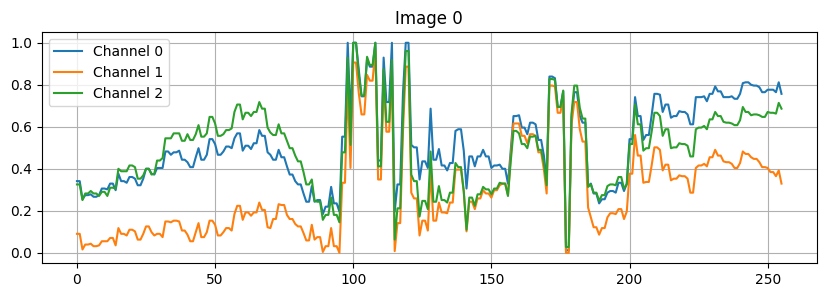

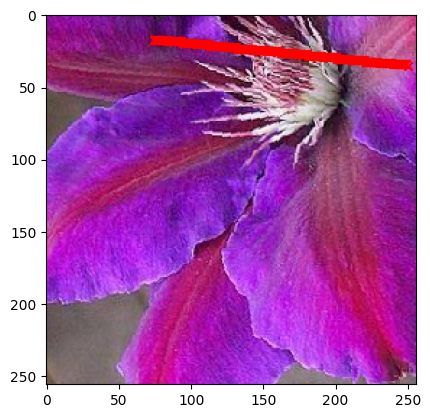

In [4]:
NUM_SAMPLES = 256
random_lines, points = random_1d_slice(batch, NUM_SAMPLES)

# Plot the lines
for i, img_lines in enumerate(random_lines):
    plt.figure(figsize=(10, 3))
    for j, line in enumerate(img_lines):
        plt.plot(line.numpy(), label=f'Channel {j}')
    plt.grid(True)
    plt.title(f'Image {i}')
    plt.legend()
    plt.show()
    plt.imshow(batch[i].permute(1, 2, 0))
    plt.scatter(points[i][0], points[i][1], c='red', marker='x')
    plt.show()
    break

In [5]:
class FlowerSlicer(torch.utils.data.Dataset):
    def __init__(self, lines: torch.Tensor):
        super().__init__()
        self.lines = lines.clone()
    
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, index):
        return self.lines[index]

In [6]:
BATCH_SIZE = 4

ds = FlowerSlicer(random_lines.view(-1, NUM_SAMPLES))
dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

len(ds), len(dl)

(192, 48)

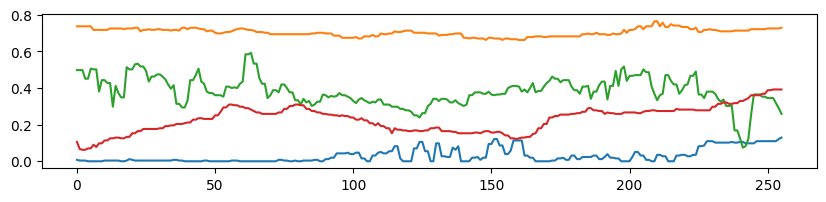

In [7]:
plt.figure(figsize=(10, 2))
for lb in dl:
    for l in lb: plt.plot(l)
    plt.show()
    break

In [8]:
KEY_SIZE = 16

def keys(batch, size = KEY_SIZE):
    ks = torch.linspace(0, NUM_SAMPLES-1, size, dtype=torch.int64)
    return batch[:,ks], ks

In [9]:
target = lb.clone()
key, ks = keys(target)
key.shape

torch.Size([4, 16])

key: torch.Size([4, 16])


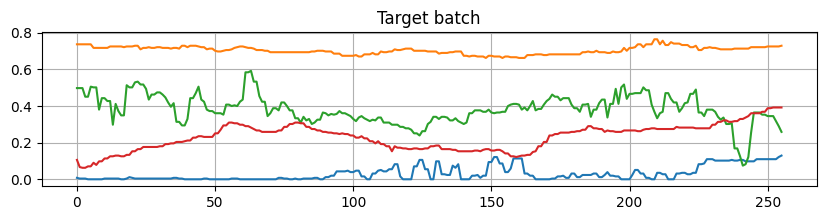

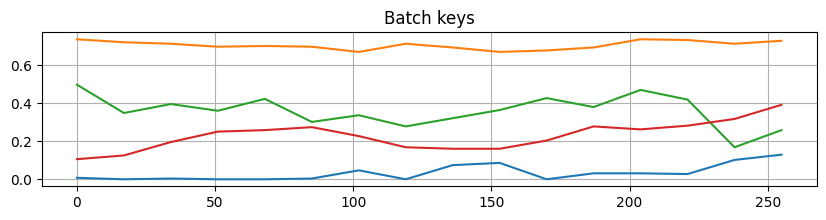

In [10]:
print('key:', key.shape)
plt.figure(figsize=(10, 2))
for l in target:
    plt.plot(l)
plt.title('Target batch')
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 2))
for k in key:
    plt.plot(ks, k)
plt.title('Batch keys')
plt.grid(True)
plt.show()

In [11]:
def periodic_linear_interp(k, x, n=NUM_SAMPLES):
    """
    Performs periodic linear interpolation
    
    Args:
        k: Key points tensor
        x: Input positions tensor
    """
    x_normalized = x * ((k.shape[1]-1)/(n-1))
    
    # Get periodic indices using modulo
    x0 = torch.floor(x_normalized).long() % k.shape[1]
    x1 = torch.ceil(x_normalized).long() % k.shape[1]
    
    # Get weights for interpolation
    w1 = x_normalized - torch.floor(x_normalized)
    w0 = 1 - w1

    # ki0 = torch.gather(k, 1, torch.stack([x0]*k.shape[0]))
    # ki1 = torch.gather(k, 1, torch.stack([x1]*k.shape[0]))

    ki0 = torch.gather(k, 1, x0)
    ki1 = torch.gather(k, 1, x1)

    return w0*ki0 + w1*ki1
    
    # return w0 * k[:, x0] + w1 * k[:, x1]

def periodic_step_interp(k, x, n=NUM_SAMPLES):
    """
    Performs periodic stepped interpolation by rounding

    Args:
        k: Key points tensor
        x: Input positions tensor
    """
    x = torch.round(x*((k.shape[1]-1)/(n-1))).long() % k.shape[1]
    return torch.gather(k, 1, x)
    # return k[:,torch.round(x*((k.shape[1]-1)/(n-1))).long() % k.shape[1]]

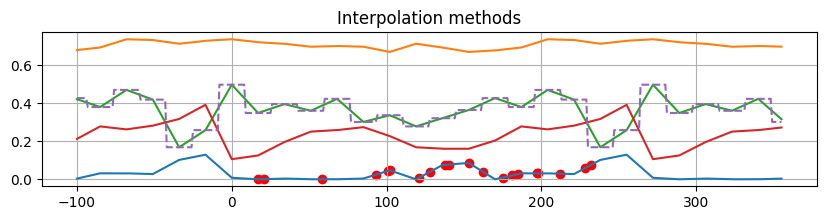

In [12]:
pad = 100

x_lin = torch.stack([torch.linspace(-pad, NUM_SAMPLES-1 + pad, NUM_SAMPLES + 2*pad)]*4)
x_rnd = torch.stack([torch.randint(0, NUM_SAMPLES-1, (20,))]*4)

linear_resample = periodic_linear_interp(key, x_lin)
step_resample = periodic_step_interp(key, x_lin)
random_resample = periodic_linear_interp(key, x_rnd)

plt.figure(figsize=(10, 2))
plt.plot(x_lin.permute(1, 0), linear_resample.permute(1, 0))
plt.plot(x_lin[2], step_resample[2], linestyle='--')
plt.scatter(x_rnd[0], random_resample[0], c='red')
plt.title("Interpolation methods")
plt.grid(True)
plt.show()

In [13]:
class PositionEncoder(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.emb_size = emb_size

    def forward(self, x):
        # indices = torch.arange(self.emb_size, device=x.device)
        # cos_mask = (indices % 2 == 0).float()
        # sin_mask = (indices % 2 == 1).float()
        # return torch.cos(x)*cos_mask + torch.sin(x)*sin_mask 
        return torch.sin(x)

In [14]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, theta = 10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        return emb

In [15]:
class Learner(nn.Module):
    def __init__(self, layer_sizes: list[int], emb_size=KEY_SIZE):
        super().__init__()

        self.pos = nn.Sequential(
            nn.Linear(1, emb_size),
            PositionEncoder(emb_size) )

        # self.pos = nn.Sequential(
        #     SinusoidalPosEmb(emb_size) )
        
        self.ffn = nn.ModuleList([nn.Sequential(
            nn.Linear(ls_in*emb_size, ls_out*emb_size), nn.ReLU() )
            for ls_in, ls_out in zip(layer_sizes, layer_sizes[:1]) ] )
        
        self.out = nn.Linear(layer_sizes[-1]*emb_size, 1)

        nn.init.normal_(self.out.weight, 0, 0.01)
        nn.init.zeros_(self.out.bias)

        nn.init.normal_(self.pos[0].weight, 0, 0.04)
        nn.init.zeros_(self.pos[0].bias)

        for l in self.ffn:
            nn.init.normal_(l[0].weight, 0, 0.08)
            nn.init.zeros_(l[0].bias)
    
    def forward(self, x, k):
        # something is still very wrong here
        z = self.pos(x.view(-1, 1))
        z = z.view(x.shape[0], -1, k.shape[1])
        z = z + k.unsqueeze(1)
        for l in self.ffn:
            z = l(z)
        y = self.out(z).squeeze()
        s = periodic_linear_interp(k, x)
        return y + s


In [23]:
KEY_SIZE = 64
target = next(iter(dl)).cuda()
target_keys, _ = keys(target, KEY_SIZE)
learner = Learner([1, 16, 16, 16, 1], KEY_SIZE).cuda()
optimizer = optim.Adam(learner.parameters(), lr=1e-4)
criterion = nn.MSELoss()

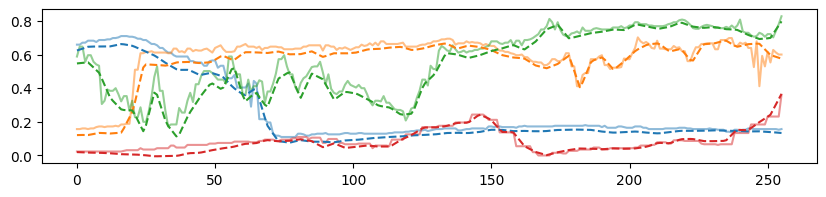

In [24]:
def plot_prediction(model, real_y, keys, device='cuda', ax=None):
    with torch.no_grad():
        model.eval()
        x = torch.linspace(0, NUM_SAMPLES-1, NUM_SAMPLES)
        x = torch.stack([x]*len(real_y)).to(device)
        pred_y = model(x, keys)
        
        # prepare data for plotting
        real_y = real_y.permute(1, 0).cpu().numpy()
        pred_y = pred_y.permute(1, 0).cpu().numpy()
        x = x.permute(1, 0).cpu().numpy()

        if ax is None:
            plt.figure(figsize=(10, 2))
            plt.plot(x, real_y, alpha=0.5)
            plt.gca().set_prop_cycle(None) # reset color cycle so that the colors match
            plt.plot(x, pred_y, linestyle='--')
            plt.show()
        else:
            ax.plot(x, real_y, alpha=0.5)
            ax.set_prop_cycle(None)
            ax.plot(x, pred_y, linestyle='--')

plot_prediction(learner, target, target_keys)

In [25]:
loss_history = []
running_loss = 0

x = torch.linspace(0, NUM_SAMPLES-1, NUM_SAMPLES)
x = torch.stack([x]*len(target)).cuda()

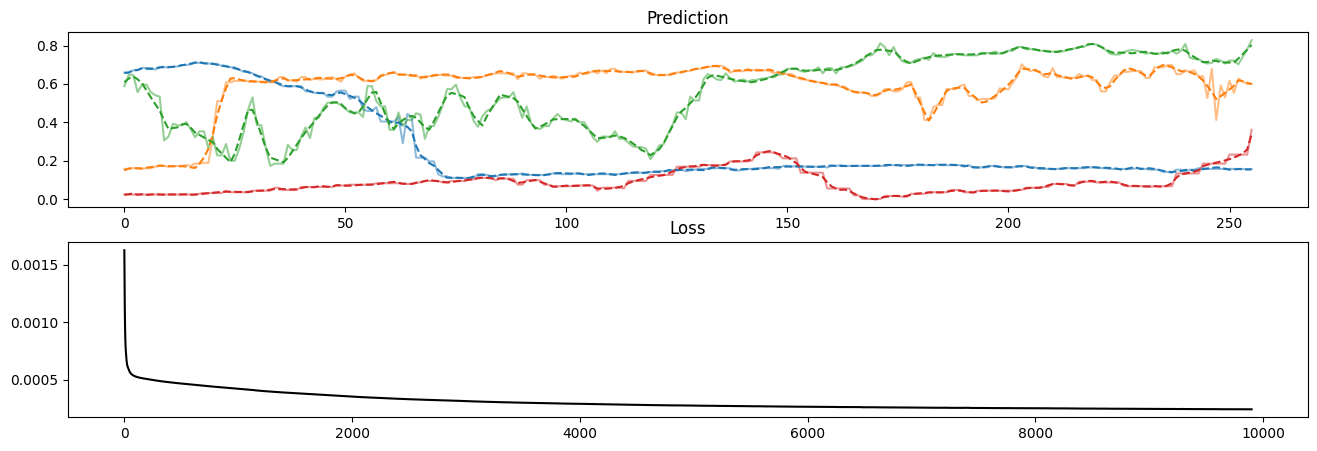

In [26]:
learner.train()
for epoch in range(10000):
    for batch in [target]: # dl:
        batch = batch.cuda()
        optimizer.zero_grad()
        key, _ = keys(batch, KEY_SIZE)
        pred = learner(x, target_keys) # key)
        loss = criterion(pred, batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_history.append(running_loss)
    running_loss = 0

    if epoch % 100 == 0:
        clear_output(wait=True)
        fig, ax = plt.subplots(2, 1, figsize=(16, 5))
        plot_prediction(learner, target, target_keys, ax=ax[0])
        ax[0].set_title('Prediction')
        ax[1].plot(loss_history, color='black')
        ax[1].set_title('Loss')
        plt.show()

In [27]:
tg_a = target[1].unsqueeze(0)
tk_a = target_keys[1].unsqueeze(0)

tg_b = target[2].unsqueeze(0)
tk_b = target_keys[2].unsqueeze(0)

tk_a.shape, target_keys.shape

(torch.Size([1, 64]), torch.Size([4, 64]))

In [28]:
tk_steps = [tk_a, tk_b]


betweens = []

for i, (l, r) in enumerate(zip(tk_steps, tk_steps[1:])):
    tk_m = (l + r) / 2
    betweens.append(tk_m)

tk_steps.insert(1, betweens[0])

print(len(tk_steps))


betweens = []

for i, (l, r) in enumerate(zip(tk_steps, tk_steps[1:])):
    tk_m = (l + r) / 2
    betweens.append(tk_m)

tk_steps.insert(1, betweens[0])
tk_steps.insert(3, betweens[1])

print(len(tk_steps))

last = tk_steps.pop()
tk_steps.insert(1, last) # move last to second position for consistent plot colors in next cell

3
5


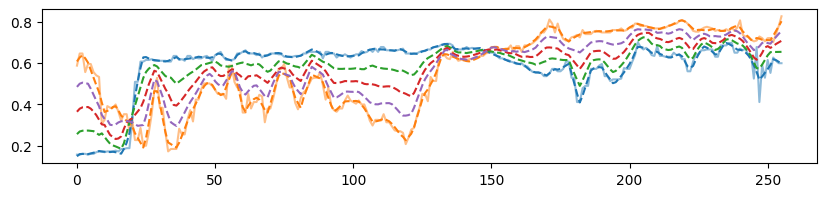

In [29]:
with torch.no_grad():
    learner.eval()
    
    x = torch.linspace(0, NUM_SAMPLES-1, NUM_SAMPLES)
    x = torch.stack([x]*len(tk_steps)).cuda()

    pred_y = learner(x, torch.cat(tk_steps, dim=0))

    pred_y = pred_y.permute(1, 0).cpu().numpy()
    x = x.permute(1, 0).cpu().numpy()

    plt.figure(figsize=(10, 2))
    plt.plot(torch.cat([tg_a, tg_b], dim=0).permute(1, 0).cpu().numpy(), alpha=0.5)
    plt.gca().set_prop_cycle(None)
    plt.plot(x, pred_y, linestyle='--')
    plt.show()
